# INL Projekt 2
## Zadanie 6 z PolEval 2019: Rozpoznawanie treści niebezpiecznych w wiadomościach

Gabriela Szczesna s17158, Juliusz Stańczyk s24206


Import bibliotek

In [1]:
import numpy as np
import re

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import collections
import pathlib

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

import tensorflow_datasets as tfds

# 1. Przygotowanie danych

Pobranie danych z dysku

In [3]:
from google.colab import drive
drive.mount('/content/drive')

train1_text_path = '/content/drive/MyDrive/INL_Pro2/task_6-1/training_set_clean_only_text.txt'
train1_tags_path = '/content/drive/MyDrive/INL_Pro2/task_6-1/training_set_clean_only_tags.txt'
test1_text_path = '/content/drive/MyDrive/INL_Pro2/Task6/task 01/test_set_clean_only_text.txt'
test1_tags_path = '/content/drive/MyDrive/INL_Pro2/Task6/task 01/test_set_clean_only_tags.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def read_file_to_list(filepath):
  with open(filepath) as file:
      text_list = [line.rstrip() for line in file]
  return text_list

In [5]:
train1_text_pre = read_file_to_list(train1_text_path)
train1_tags = read_file_to_list(train1_tags_path)
test1_text_pre = read_file_to_list(test1_text_path)
test1_tags = read_file_to_list(test1_tags_path)

Przykład próbki tekstu

In [6]:
print(train1_text_pre[2])

@anonymized_account @anonymized_account Super, polski premier składa kwiaty na grobach kolaborantów. Ale doczekaliśmy czasów.


Formatowanie tekstu i usunięcie nazw użytkowników z treści

In [7]:
def text_cleanup(tweet_text):
  tweet_text = tweet_text.strip()
  tweet_text = re.sub(r'@anonymized_account', '', tweet_text)
  tweet_text = re.sub(r'[^\w\s]', '', tweet_text)
  tweet_text = re.sub(r'[0-9]', '', tweet_text)
  tweet_text = re.sub(r' +', ' ', tweet_text)
  tweet_text = tweet_text.lower()
  tweet_text = tweet_text.strip()
  
  return tweet_text

In [8]:
train1_text = [text_cleanup(line) for line in train1_text_pre]
test1_text = [text_cleanup(line) for line in test1_text_pre]

Przykład zformatowanej próbki tesktu

In [9]:
print(text_cleanup(train1_text[2]))

super polski premier składa kwiaty na grobach kolaborantów ale doczekaliśmy czasów


In [10]:
#dodalem usuniecie sstarych bo mialem problemy ze juz istnieją, mimo uruchomienia ponownego srodowiska 
!rm -r train_dir
!rm -r train_dir/0
!rm -r train_dir/1
!rm -r test_dir
!rm -r test_dir/0
!rm -r test_dir/1

rm: cannot remove 'train_dir/0': No such file or directory
rm: cannot remove 'train_dir/1': No such file or directory
rm: cannot remove 'test_dir/0': No such file or directory
rm: cannot remove 'test_dir/1': No such file or directory


In [11]:
!mkdir train_dir
!mkdir train_dir/0
!mkdir train_dir/1
!mkdir test_dir
!mkdir test_dir/0
!mkdir test_dir/1

Zmiana formatu zapisu danych w celu utworzenia datasetu

In [12]:
for i in range(len(train1_text)):
  if train1_tags[i] == '0':
    with open("train_dir/0/text{}.txt".format(i), 'x', encoding='utf-8') as f:
      f.write(train1_text[i])
  elif train1_tags[i] == '1':
    with open("train_dir/1/text{}.txt".format(i), 'x', encoding='utf-8') as f:
      f.write(train1_text[i])
  else:
    print("Error: Unknown tag")

In [13]:
for i in range(len(test1_text)):
  if test1_tags[i] == '0':
    with open("test_dir/0/text{}.txt".format(i), 'x', encoding='utf-8') as f:
      f.write(test1_text[i])
  elif test1_tags[i] == '1':
    with open("test_dir/1/text{}.txt".format(i), 'x', encoding='utf-8') as f:
      f.write(test1_text[i])
  else:
    print("Error: Unknown tag")

Utworzenie datasetu z pobranych danych

In [14]:
batch_size = 32
seed = 42

raw_train_ds = utils.text_dataset_from_directory(
    "train_dir",
    #batch_size=batch_size,
    validation_split=None,
    subset=None,
    seed=seed)

raw_test_ds = utils.text_dataset_from_directory(
    "test_dir",
    #batch_size=batch_size,
    validation_split=None,
    subset=None,
    seed=seed)

Found 10041 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [15]:
#tf.reshape(raw_train_ds,shape=(32, 1))

In [16]:
raw_train_ds.element_spec
raw_test_ds.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Przykłady próbek z róznych klas

In [17]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(5):
    print("tweet: ", text_batch.numpy()[i])
    print("tag:", label_batch.numpy()[i])

tweet:  b'pelikanem to ty jestes skoro wierzysz \xc5\xbce grosicki by\xc5\x82 blisko'
tag: 1
tweet:  b'fakt przecie\xc5\xbc drugiego takiego kreatyna w ca\xc5\x82ej galaktyce nie ma'
tag: 0
tweet:  b'w jednej z powt\xc3\xb3rek by\xc5\x82o to dobrze wida\xc4\x87'
tag: 0
tweet:  b'gala jest w kretynskim momencie i nagroda ni to za sezon ni to za rok'
tag: 0
tweet:  b'nie wiem nie interesowalem sie'
tag: 0


In [18]:
#for example, label in raw_train_ds.take(1):
  #print('tweet: ', example.numpy())
  #print('label: ', label.numpy())

In [19]:
#for i, label in enumerate(raw_train_ds.class_names):
  #print("Label", i, "corresponds to", label)

In [20]:
#raw_train_ds.element_spec
#raw_test_ds.element_spec


In [21]:
#BUFFER_SIZE = 10000
#BATCH_SIZE = 64

In [22]:
#train_dataset = raw_train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#test_dataset = raw_test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [23]:
#for text, label in train_dataset.take(1):
  #print('tweet: ', text.numpy()[1])
  #print()
  #print('label: ', label.numpy()[1])


Standaryzacja, tokenizacja i wektoryzacja danych

In [24]:
VOCAB_SIZE = 10000

binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary') #worek slow

In [25]:
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int', #indeksy liczb calkowitych
    output_sequence_length=MAX_SEQUENCE_LENGTH)

In [26]:
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

Drukowanie wyniku

In [27]:
def binary_vec(text, label):
  text = tf.expand_dims(text, -1)
  return binary_vectorize_layer(text), label

In [28]:
def int_vec(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label

In [29]:
# Retrieve a batch (of 32 reviews and labels) from the dataset.
text_batch, label_batch = next(iter(raw_train_ds))
pytanie, label = text_batch[0], label_batch[0]
print("Question", pytanie)
print("Label", label)

Question tf.Tensor(b'o matko jeste\xc5\x9b w koszulce mistrzu', shape=(), dtype=string)
Label tf.Tensor(0, shape=(), dtype=int32)


Wynik dla Binary oraz Int

In [30]:
print("'binary' vectorized question:",
      binary_vec(pytanie, label)[0])
print("'int' vectorized question:",
      int_vec(pytanie, label)[0])

'binary' vectorized question: tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 10000), dtype=float32)
'int' vectorized question: tf.Tensor(
[[  16 1895   80    4 3103 3034    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    

Test słownika

In [31]:
print("Slowo dla 997", int_vectorize_layer.get_vocabulary()[997])
print("Slowo dla 777", int_vectorize_layer.get_vocabulary()[777])
print("Rozmiar slownika: {}".format(len(int_vectorize_layer.get_vocabulary())))

Slowo dla 997 drugą
Slowo dla 777 powiem
Rozmiar slownika: 10000


Wcześniejsze funkcje zastosowane już na zestawach danych

In [32]:
binary_train_ds = raw_train_ds.map(binary_vec)
#binary_val_ds = raw_val_ds.map(binary_vectorize_text)
binary_test_ds = raw_test_ds.map(binary_vec)

int_train_ds = raw_train_ds.map(int_vec)
#int_val_ds = raw_val_ds.map(int_vectorize_text)
int_test_ds = raw_test_ds.map(int_vec)

Optymalizacja wydajnosc - przechowywanie danych w pamięci oraz jednoczesne wstępne przetwarzanie i wykonywanie modelu podczas uczenia

In [33]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
binary_train_ds = configure_dataset(binary_train_ds)
#binary_val_ds = configure_dataset(binary_val_ds)
binary_test_ds = configure_dataset(binary_test_ds)

int_train_ds = configure_dataset(int_train_ds)
#int_val_ds = configure_dataset(int_val_ds)
int_test_ds = configure_dataset(int_test_ds)

# 2. Zbudowanie modelu sieci neuronowej

funkcje do generowania miary f1

In [35]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

model1 = tf.keras.Sequential([
    layers.Dense(20, activation='relu'),
    layers.Dense(15, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(5, activation='softplus'),
    ])

model1.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy', f1_m])

#es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

model1.fit(binary_train_ds, epochs=15)


Epoch 1/15
314/314 [==============================] - 4s 9ms/step - loss: 0.5490 - accuracy: 0.9133 - f1_m: 0.1622
Epoch 2/15
314/314 [==============================] - 2s 6ms/step - loss: 0.2184 - accuracy: 0.9153 - f1_m: 0.1606
Epoch 3/15
314/314 [==============================] - 2s 7ms/step - loss: 0.1151 - accuracy: 0.9572 - f1_m: 0.1604
Epoch 4/15
314/314 [==============================] - 2s 5ms/step - loss: 0.0579 - accuracy: 0.9831 - f1_m: 0.1604
Epoch 5/15
314/314 [==============================] - 1s 5ms/step - loss: 0.0313 - accuracy: 0.9921 - f1_m: 0.1605
Epoch 6/15
314/314 [==============================] - 2s 5ms/step - loss: 0.0203 - accuracy: 0.9951 - f1_m: 0.1611
Epoch 7/15
314/314 [==============================] - 2s 5ms/step - loss: 0.0141 - accuracy: 0.9965 - f1_m: 0.1631
Epoch 8/15
314/314 [==============================] - 2s 5ms/step - loss: 0.0100 - accuracy: 0.9980 - f1_m: 0.1665
Epoch 9/15
314/314 [==============================] - 2s 5ms/step - loss: 0.0072

In [37]:
model2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model2.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy', f1_m])

#es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

model2.fit(binary_train_ds, epochs=15)

Epoch 1/15


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


314/314 [==============================] - 4s 11ms/step - loss: 0.3952 - accuracy: 0.9121 - f1_m: 0.1395
Epoch 2/15
314/314 [==============================] - 3s 10ms/step - loss: 0.1502 - accuracy: 0.9454 - f1_m: 0.1521
Epoch 3/15
314/314 [==============================] - 3s 10ms/step - loss: 0.0810 - accuracy: 0.9719 - f1_m: 0.1522
Epoch 4/15
314/314 [==============================] - 4s 12ms/step - loss: 0.0466 - accuracy: 0.9868 - f1_m: 0.1524
Epoch 5/15
314/314 [==============================] - 4s 11ms/step - loss: 0.0285 - accuracy: 0.9923 - f1_m: 0.1524
Epoch 6/15
314/314 [==============================] - 3s 10ms/step - loss: 0.0186 - accuracy: 0.9957 - f1_m: 0.1524
Epoch 7/15
314/314 [==============================] - 3s 10ms/step - loss: 0.0128 - accuracy: 0.9975 - f1_m: 0.1524
Epoch 8/15
314/314 [==============================] - 4s 13ms/step - loss: 0.0093 - accuracy: 0.9981 - f1_m: 0.1524
Epoch 9/15
314/314 [==============================] - 3s 11ms/step - loss: 0.0072 -

# 3. Ewaluacja wyników

Dokładność modelu 1:
- dane treningowe: 100%
- dane testowe: 87%

Miara F1 dla modelu 1:
- dane treningowe: 0.17
- dane testowe: 0.27

32/32 [==============================] - 0s 7ms/step - loss: 1.3106 - accuracy: 0.8600 - f1_m: 0.2774
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                200020    
                                                                 
 dense_1 (Dense)             (None, 15)                315       
                                                                 
 dense_2 (Dense)             (None, 10)                160       
                                                                 
 dense_3 (Dense)             (None, 5)                 55        
                                                                 
Total params: 200,550
Trainable params: 200,550
Non-trainable params: 0
_________________________________________________________________


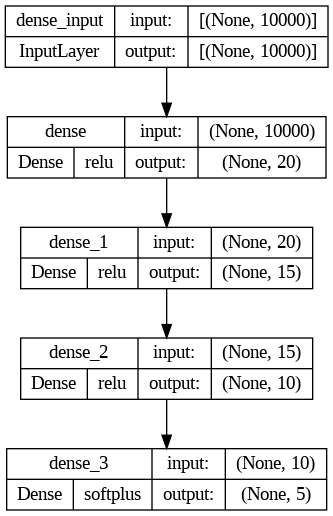

In [41]:
model1.evaluate(binary_train_ds)
model1.evaluate(binary_test_ds)
model1.summary()
tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_activations=True)


Dokładność modelu 2:
- dane treningowe: 100%
- dane testowe: 87%

Miara F1 dla modelu 2:
- dane treningowe: 0.15
- dane testowe: 0.24

32/32 [==============================] - 0s 4ms/step - loss: 1.0251 - accuracy: 0.8720 - f1_m: 0.2362
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               1280128   
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 1,280,773
Trainable params: 1,280,773
Non-trainable params: 0
_________________________________________________________________


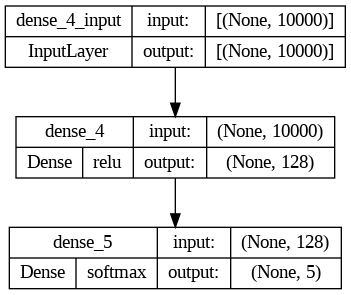

In [42]:
model2.evaluate(binary_train_ds)
model2.evaluate(binary_test_ds)
model2.summary()
tf.keras.utils.plot_model(model2, show_shapes=True, show_layer_activations=True)